In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
sheet = pd.read_excel('data_input/氧化铝周度库存.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['氧化铝周度库存'].last_valid_index()

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=30, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()


,氧化铝周度产量,氧化铝周度表需/4WMA,氧化铝：库存：中国（周）1周环差,氧化铝周度库存
2025-12-15,NaN,NaN,NaN,NaN
2025-12-16,NaN,NaN,NaN,NaN
2025-12-17,NaN,NaN,NaN,NaN
2025-12-18,NaN,NaN,NaN,NaN
2025-12-19,NaN,NaN,NaN,NaN


In [5]:
sheet.loc[:last_day, '氧化铝周度库存'] = sheet.loc[:last_day, '氧化铝周度库存'].interpolate(method='linear')


In [6]:
file_path1 = os.path.expanduser("eta/氧化铝周度表需_合并数据.xlsx") 
sheet1 = pd.ExcelFile(file_path1).parse('Sheet1')
sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
sheet1 = sheet1.drop(columns=['实际值'])
sheet1 = sheet1.rename(columns={'氧化铝周度表需/4WMA': '预测值'})
sheet1 = sheet1.dropna()

sheet1 = sheet1.sort_values('Date', ascending=True)
sheet1.tail()

,Date,预测值
4,2025-11-14,181.00
3,2025-11-21,181.68
2,2025-11-28,182.57
1,2025-12-05,183.16
0,2025-12-12,183.75


In [7]:
file_path2 = os.path.expanduser("eta/氧化铝周度产量_合并数据.xlsx") 
sheet2 = pd.ExcelFile(file_path2).parse('Sheet1')
sheet2['Date'] = pd.to_datetime(sheet2['Date'], errors='coerce')
sheet2 = sheet2.drop(columns=['真实值'])
sheet2 = sheet2.dropna()

sheet2 = sheet2.sort_values('Date', ascending=True)
sheet2.head()

,Date,预测值
5,2025-11-14,177.2
4,2025-11-21,178.5
3,2025-11-28,157.0
2,2025-12-05,147.6
1,2025-12-12,160.4


In [8]:
sheet

,氧化铝周度产量,氧化铝周度表需/4WMA,氧化铝：库存：中国（周）1周环差,氧化铝周度库存
2017-02-03,130.4030,NaN,NaN,NaN
2017-02-10,130.4030,NaN,NaN,NaN
2017-02-17,130.4030,NaN,NaN,NaN
2017-02-24,130.4030,NaN,NaN,NaN
2017-03-03,146.3749,NaN,NaN,NaN
...,...,...,...,...
2025-12-15,NaN,NaN,NaN,NaN
2025-12-16,NaN,NaN,NaN,NaN
2025-12-17,NaN,NaN,NaN,NaN
2025-12-18,NaN,NaN,NaN,NaN


In [9]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['氧化铝周度表需/4WMA'] = sheet_daily['氧化铝周度表需/4WMA'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

# 合并 sheet2 的美元指数数据 
sheet_daily = pd.merge(
    sheet_daily,
    sheet2[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['氧化铝周度产量'] = sheet_daily['氧化铝周度产量'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])


sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-06-01')]
sheet_daily.tail(10)

,Date,氧化铝周度产量,氧化铝周度表需/4WMA,氧化铝：库存：中国（周）1周环差,氧化铝周度库存
478,2025-12-08,NaN,NaN,NaN,NaN
479,2025-12-09,NaN,NaN,NaN,NaN
480,2025-12-10,NaN,NaN,NaN,NaN
481,2025-12-11,NaN,NaN,NaN,NaN
482,2025-12-12,160.4,183.75,NaN,NaN
483,2025-12-15,NaN,NaN,NaN,NaN
484,2025-12-16,NaN,NaN,NaN,NaN
485,2025-12-17,NaN,NaN,NaN,NaN
486,2025-12-18,NaN,NaN,NaN,NaN
487,2025-12-19,175.6,NaN,NaN,NaN


In [10]:
# 添加新列 山东汽油裂解差_预测
sheet_daily['氧化铝：库存：中国（周）1周环差_预测'] = sheet_daily['氧化铝周度产量'] - sheet_daily['氧化铝周度表需/4WMA'] 

diff_col = '氧化铝：库存：中国（周）1周环差_预测'   # 环差列
pred_col = '氧化铝周度库存_预测'                    # 预测列

# ── 1. 找到最后一个已公布的周度库存及日期 ──────────────────────────
last_valid_idx   = sheet['氧化铝周度库存'].last_valid_index()     # Timestamp
last_valid_value = sheet.at[last_valid_idx, '氧化铝周度库存']

# ── 2. 在日度表中新建预测列，全 NaN 初始化 ────────────────────────
sheet_daily[pred_col] = np.nan

# ── 3. 找到日度表中与 last_valid_idx 对齐（或其后的第一天）的位置 ──
if last_valid_idx in sheet_daily['Date'].values:
    start_row = sheet_daily.index[sheet_daily['Date'] == last_valid_idx][0]
else:
    start_row = sheet_daily.index[sheet_daily['Date'] > last_valid_idx][0]

# ── 4. 写入起始库存 ──────────────────────────────────────────────
sheet_daily.at[start_row, pred_col] = last_valid_value

# ── 5. 一次性累加环差并写回预测列 ────────────────────────────────
#     (1) 先取 start_row 及以后所有环差
#     (2) 缺口 → 0  （若确定无缺口，删掉 .fillna(0)）
#     (3) cumsum 后再 shift 一位，使首日增量为 0
section_cumsum = (
    sheet_daily.loc[start_row:, diff_col]
        .fillna(0)         # 可删
        .cumsum()
        .shift(fill_value=0)
)

sheet_daily.loc[start_row:, pred_col] = last_valid_value + section_cumsum

sheet_daily.tail()

,Date,氧化铝周度产量,氧化铝周度表需/4WMA,氧化铝：库存：中国（周）1周环差,氧化铝周度库存,氧化铝：库存：中国（周）1周环差_预测,氧化铝周度库存_预测
483,2025-12-15,NaN,NaN,NaN,NaN,NaN,391.24
484,2025-12-16,NaN,NaN,NaN,NaN,NaN,391.24
485,2025-12-17,NaN,NaN,NaN,NaN,NaN,391.24
486,2025-12-18,NaN,NaN,NaN,NaN,NaN,391.24
487,2025-12-19,175.6,NaN,NaN,NaN,NaN,391.24


In [11]:
last_day = sheet_daily['Date'][sheet_daily['氧化铝周度库存'].last_valid_index()]

---

In [12]:
# 创建历史数据部分

historical = sheet_daily[sheet_daily['Date'] <= last_day][['Date', '氧化铝周度库存']]
historical.columns = ['Date', '氧化铝周度库存']

# 创建预测数据部分 
forecast = sheet_daily[sheet_daily['Date'] > last_day][['Date', '氧化铝周度库存_预测']]
forecast.columns = ['Date', '氧化铝周度库存_预测']

# 合并历史和预测数据
merged_df_daily = pd.concat([historical, forecast], axis=0, join='outer')
merged_df_daily = merged_df_daily.sort_values('Date').reset_index(drop=True)
merged_df_daily = merged_df_daily.sort_values(by='Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
# 去掉氧化铝周度库存和氧化铝周度库存_预测均为空值的行
# 只保留周五的氧化铝周度库存_预测
merged_df_daily['Date'] = pd.to_datetime(merged_df_daily['Date'])
# 获取日期的星期几（0是星期一，4是星期五）
merged_df_daily['weekday'] = merged_df_daily['Date'].dt.weekday
# 对于非周五的日期，将预测值设为NaN
merged_df_daily.loc[merged_df_daily['weekday'] != 4, '氧化铝周度库存_预测'] = np.nan
# 将日期转回字符串格式
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
# 删除辅助列
merged_df_daily = merged_df_daily.drop(columns=['weekday'])

merged_df_daily = merged_df_daily.dropna(subset=['氧化铝周度库存', '氧化铝周度库存_预测'], how='all')

merged_df_daily.to_excel('eta/氧化铝周度库存_合并数据.xlsx', index=False,float_format='%.6f')
merged_df_daily.head()

,Date,氧化铝周度库存,氧化铝周度库存_预测
157,2025/12/19,NaN,391.24
152,2025/12/12,NaN,414.59
147,2025/12/05,NaN,450.15
142,2025/11/28,NaN,475.72
137,2025/11/21,NaN,478.90


In [13]:
# 创建历史数据部分
historical_monthly = sheet_daily[sheet_daily['Date'] <= last_day][['Date', '氧化铝周度库存']]
historical_monthly.columns = ['Date', '氧化铝周度库存']

# 创建预测数据部分 
forecast_monthly = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2024-10-01')][['Date', '氧化铝周度库存_预测']]
forecast_monthly.columns = ['Date', '氧化铝周度库存_预测']

merged_df_monthly = pd.merge(historical_monthly, forecast_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly.to_excel('eta/氧化铝周度库存_月度数据.xlsx', index=False,float_format= '%.4f')
merged_df_monthly

,Date,氧化铝周度库存,氧化铝周度库存_预测
30,2025/12/31,NaN,418.6600
29,2025/11/30,478.800,479.0875
28,2025/10/31,463.480,NaN
27,2025/09/30,443.400,NaN
26,2025/08/31,420.080,NaN
25,2025/07/31,396.700,NaN
24,2025/06/30,383.050,NaN
23,2025/05/31,385.760,NaN
22,2025/04/30,399.250,NaN
21,2025/03/31,392.050,NaN


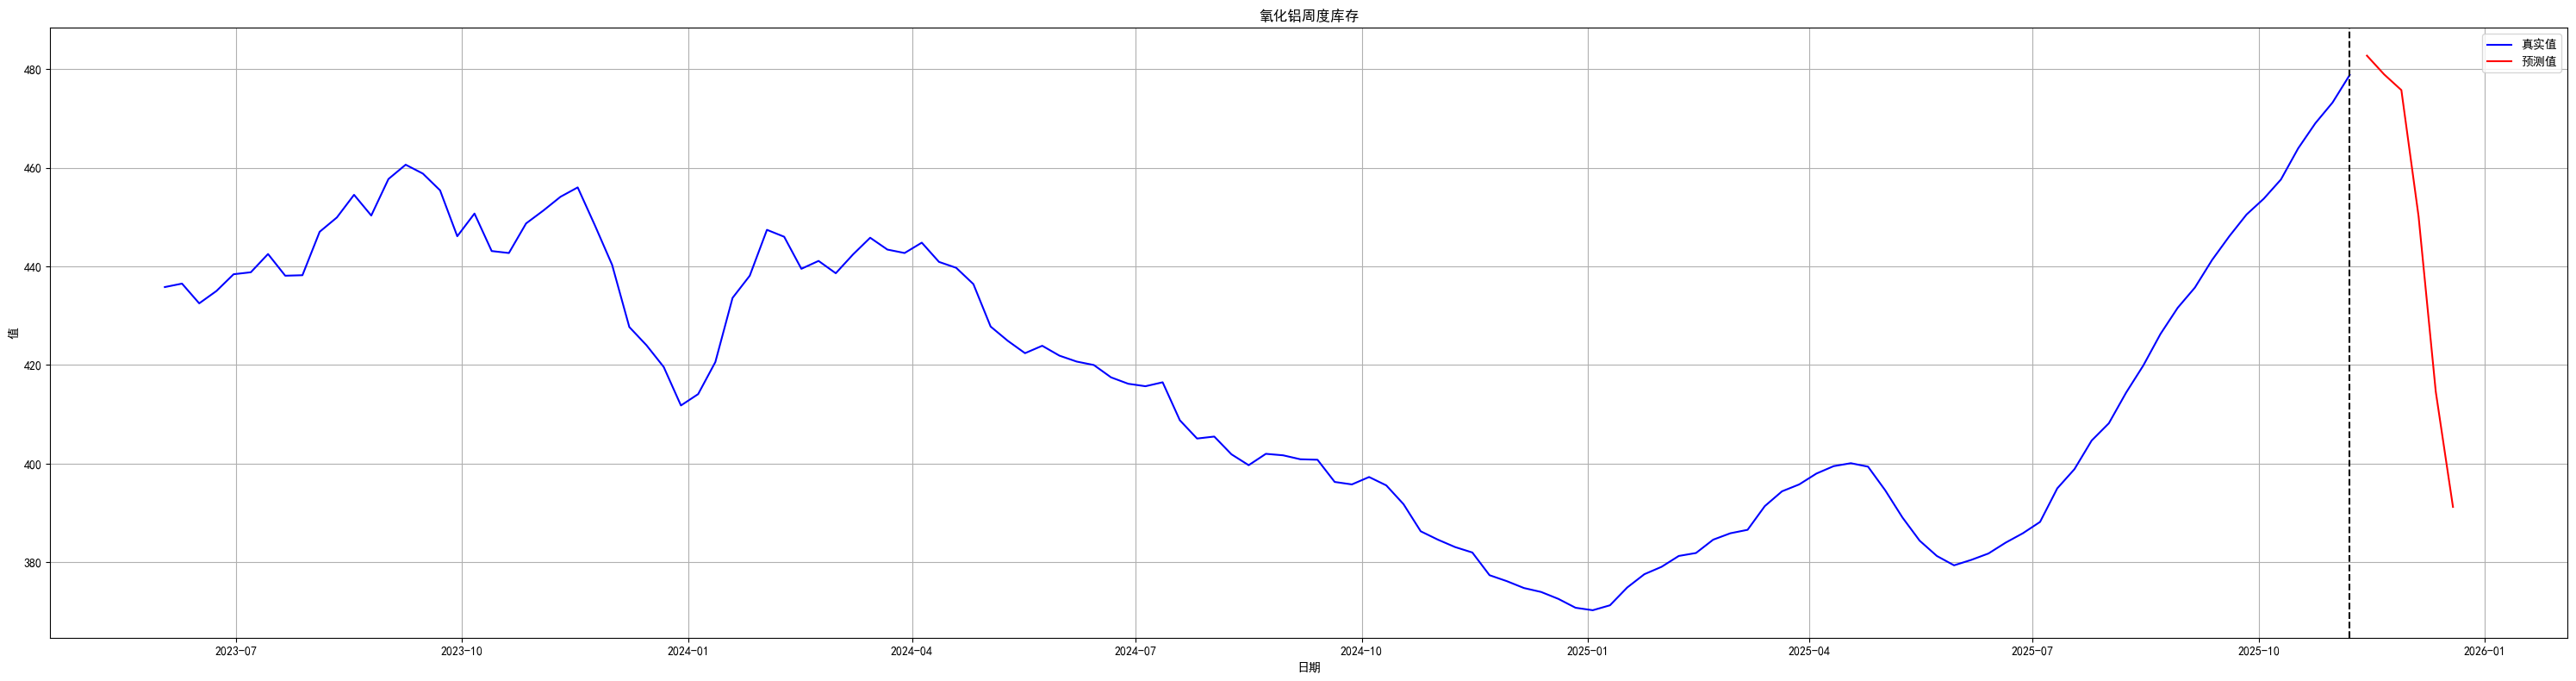

In [14]:
# 设置图形大小
plt.figure(figsize=(30, 8))

merged_df_daily_plot = merged_df_daily.copy()
merged_df_daily_plot['Date'] = pd.to_datetime(merged_df_daily_plot['Date'])

# 绘制真实值曲线(蓝色)
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['氧化铝周度库存'], color='blue', label='真实值')
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['氧化铝周度库存_预测'], color='red', label='预测值')

avline_date = pd.to_datetime(last_day)
plt.axvline(x=avline_date, color='black', linestyle='--')

# 设置图例
plt.legend()

# 设置标题和标签
plt.title('氧化铝周度库存')
plt.xlabel('日期')
plt.ylabel('值')
plt.grid(True)
plt.tight_layout()
plt.show()

---

In [15]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.铝_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "氧化铝周度库存"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [16]:
from Lcel import update_excel_data
file_path = "eta/1.铝_数据上传.xlsx"
sheet_name = "详情页"
identifier = "氧化铝周度库存"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
